In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
from pystac.extensions.eo import pystac 
from pystac_client import Client
import pystac_client   
from pystac.extensions.eo import EOExtension as eo
import odc 
from odc.stac import stac_load



import planetary_computer as pc
# Pass your API key here
pc.settings.set_subscription_key('e303e672bfc24a2982abf9b37bc3e9e8')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

In [3]:
crop_presence_data = pd.read_csv("Crop_Location_Data.csv")
# Extract the latitude and longitude from the combined column
crop_presence_data[['Latitude', 'Longitude']] = crop_presence_data['Latitude and Longitude'].str.extract(r'\((.*), (.*)\)')
crop_presence_data.head()

,Latitude and Longitude,Class of Land,Latitude,Longitude
0,"(10.323727047081501, 105.2516346045924)",Rice,10.323727047081501,105.2516346045924
1,"(10.322364360592521, 105.27843410554115)",Rice,10.322364360592521,105.27843410554115
2,"(10.321455902933202, 105.25254306225168)",Rice,10.321455902933202,105.25254306225168
3,"(10.324181275911162, 105.25118037576274)",Rice,10.324181275911162,105.25118037576274
4,"(10.324635504740822, 105.27389181724476)",Rice,10.324635504740822,105.27389181724476


In [4]:
def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    bbox_of_interest = (float(latlong[1]) , float(latlong[0]), float(latlong[1]) , float(latlong[0]))
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assests
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    vh = data["vh"].astype("float").values.tolist()[0][0]
    vv = data["vv"].astype("float").values.tolist()[0][0]
    return vh,vv

In [5]:
## Function call to extract VV,VH Values
time_slice = "2020-01-01/2020-12-31"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

100%|██████████| 600/600 [02:23<00:00,  4.17it/s]


In [6]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [8]:
!pip install lightgbm

  Using cached lightgbm-3.3.5-py3-none-manylinux1_x86_64.whl (2.0 MB)


In [9]:
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb


In [10]:
# Additional feature engineering
vh_vv_data["vv_vh_ratio"] = vh_vv_data["vv"] / vh_vv_data["vh"]

crop_data = combine_two_datasets(crop_presence_data, vh_vv_data)
crop_data.head()

crop_data = crop_data[['vh', 'vv', 'vv_vh_ratio', 'Class of Land']]

X = crop_data.drop(columns=['Class of Land']).values
y = crop_data['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=40)

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Feature selection
selector = SelectKBest(f_classif, k=3)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# LightGBM Model selection and hyperparameter tuning
model = lgb.LGBMClassifier(random_state=42)
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_selected, y_train)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: bootstrap
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split
[LightGBM] [Warning] Unknown parameter: bootstrap
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[LightGBM] [Warning] min_data_in_leaf is set with min_samples_leaf=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Unknown parameter: min_samples_split


In [11]:
# defined plot matrix function
def plot_confusion_matrix(true_value, predicted_value, title, labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparison.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value, predicted_value)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

LightGBM Insample Accuracy 94.52%
              precision    recall  f1-score   support

    Non Rice       0.94      0.95      0.95       209
        Rice       0.95      0.94      0.95       211

    accuracy                           0.95       420
   macro avg       0.95      0.95      0.95       420
weighted avg       0.95      0.95      0.95       420



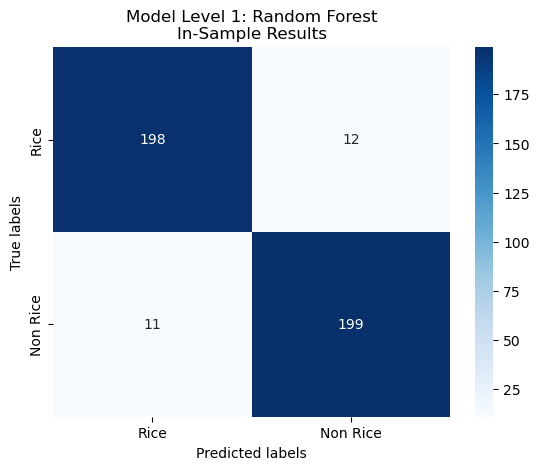

In [17]:
# Evaluate the LightGBM model
insample_predictions = best_model.predict(X_train_selected)
print("LightGBM Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions, y_train)))
print(classification_report(insample_predictions, y_train))
plot_confusion_matrix(y_train, insample_predictions, "Model Level 1: Random Forest\nIn-Sample Results", ['Rice', 'Non Rice'])

LightGBM Outsample Accuracy 86.11%
              precision    recall  f1-score   support

    Non Rice       0.91      0.80      0.85        90
        Rice       0.82      0.92      0.87        90

    accuracy                           0.86       180
   macro avg       0.87      0.86      0.86       180
weighted avg       0.87      0.86      0.86       180



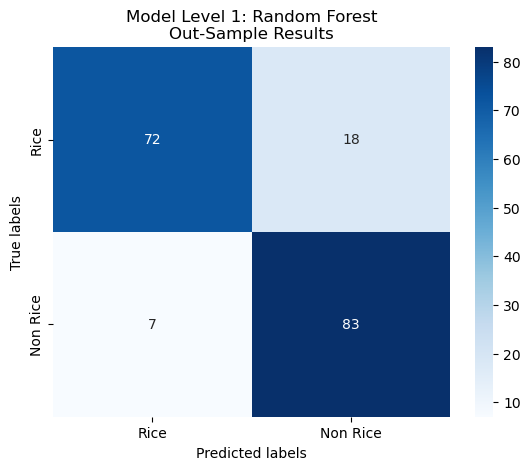

In [18]:
outsample_predictions = best_model.predict(X_test_selected)
print("LightGBM Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))
plot_confusion_matrix(y_test, outsample_predictions, "Model Level 1: Random Forest\nOut-Sample Results", ['Rice', 'Non Rice'])

In [8]:
# Additional feature engineering
vh_vv_data["vv_vh_ratio"] = vh_vv_data["vv"] / vh_vv_data["vh"]

crop_data = combine_two_datasets(crop_presence_data, vh_vv_data)
crop_data.head()

crop_data = crop_data[['vh', 'vv', 'vv_vh_ratio', 'Class of Land']]

X = crop_data.drop(columns=['Class of Land']).values
y = crop_data['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=40)

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Feature selection
selector = SelectKBest(f_classif, k=3)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Model selection and hyperparameter tuning
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_selected, y_train)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=10; total ti

In [15]:
# defined plot matrix function
def plot_confusion_matrix(true_value, predicted_value, title, labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparison.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value, predicted_value)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(title)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)


In [ ]:
# Evaluate the updated model
insample_predictions = best_model.predict(X_train_selected)
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions, y_train)))
print(classification_report(insample_predictions, y_train))
plot_confusion_matrix(y_train, insample_predictions, "Model Level 1: Random Forest\nIn-Sample Results", ['Rice', 'Non Rice'])

Outsample Accuracy 85.56%
              precision    recall  f1-score   support

    Non Rice       0.88      0.82      0.85        90
        Rice       0.83      0.89      0.86        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



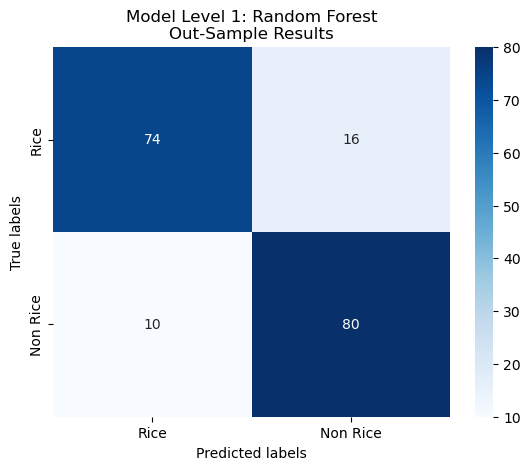

In [11]:
outsample_predictions = best_model.predict(X_test_selected)
print("Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))
plot_confusion_matrix(y_test, outsample_predictions, "Model Level 1: Random Forest\nOut-Sample Results", ['Rice', 'Non Rice'])

In [12]:
!pip install xgboost

  Using cached xgboost-1.7.4-py3-none-manylinux2014_x86_64.whl (193.6 MB)


In [17]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
crop_data['Class of Land'] = le.fit_transform(crop_data['Class of Land'])

In [19]:
from sklearn.preprocessing import LabelEncoder

# Separate features and target variable
X = crop_presence_data['Latitude and Longitude'].str.strip('()').str.split(',', expand=True).astype(float)
y = crop_presence_data['Class of Land']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Train the XGBoost model
model1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model1.fit(X_train, y_train)

# Make predictions
insample_predictions = model1.predict(X_train)
outsample_predictions = model1.predict(X_test)

# Calculate accuracy
in_sample_accuracy = accuracy_score(y_train, insample_predictions)
out_sample_accuracy = accuracy_score(y_test, outsample_predictions)

print("In-sample accuracy:", in_sample_accuracy)
print("Out-of-sample accuracy:", out_sample_accuracy)

# Feature selection for X_test
X_test_selected = X_test[:, [0, 1]]  # Selecting only the first two features (latitude and longitude)


In-sample accuracy: 1.0
Out-of-sample accuracy: 1.0


Insample Accuracy 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       242
           1       1.00      1.00      1.00       238

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480



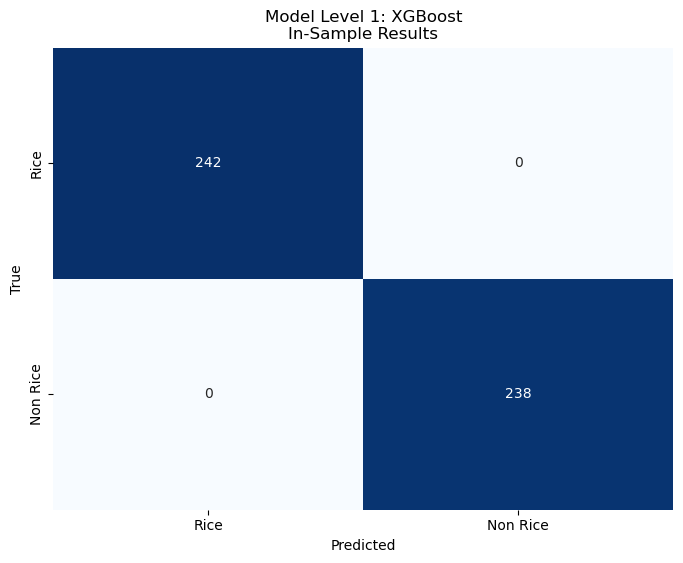

Outsample Accuracy 100.00%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        62

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



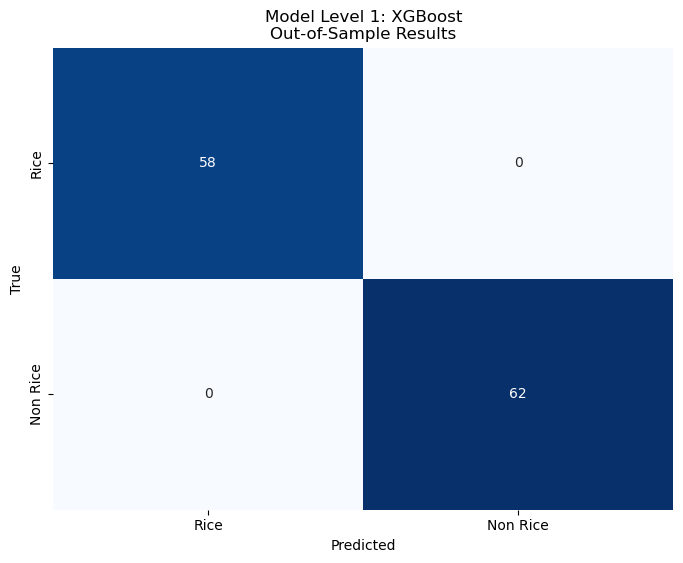

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate the updated model
insample_predictions = model1.predict(X_train)
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions, y_train)))
print(classification_report(insample_predictions, y_train))
plot_confusion_matrix(y_train, insample_predictions, "Model Level 1: XGBoost\nIn-Sample Results", ['Rice', 'Non Rice'])

# Out-of-sample evaluation
outsample_predictions = model1.predict(X_test_selected)
print("Outsample Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))
plot_confusion_matrix(y_test, outsample_predictions, "Model Level 1: XGBoost\nOut-of-Sample Results", ['Rice', 'Non Rice'])


In [49]:
# Code for the submission file
test_file = pd.read_csv('challenge_1_submission_template.csv')
test_file.head()

# Get Sentinel-1-RTC Data
time_slice = "2020-03-20/2020-03-21"
assets = ['vh', 'vv']
vh_vv = []
for coordinates in tqdm(test_file['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates, time_slice, assets))
submission_vh_vv_data = pd.DataFrame(vh_vv, columns=['vh', 'vv'])

# Additional feature engineering for the submission dataset
submission_vh_vv_data["vv_vh_ratio"] = submission_vh_vv_data["vv"] / submission_vh_vv_data["vh"]

# Feature scaling
submission_coordinates = test_file['Latitude and Longitude'].str.strip('()').str.split(',', expand=True).astype(float)
transformed_submission_data = scaler.transform(submission_coordinates)

# Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

# Combining the results into a dataframe
submission_df = pd.DataFrame({'Latitude and Longitude': test_file['Latitude and Longitude'].values, 'Class of Land': final_prediction_series.values})

# Displaying the sample submission dataframe
display(submission_df)

# Dumping the predictions into a csv file
submission_df.to_csv("challenge_1_submission_rice_crop_prediction_new.csv", index=False)


100%|██████████| 250/250 [00:49<00:00,  5.10it/s]


,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",1
1,"(10.561107033461816, 105.12772097986661)",0
2,"(10.623790611954897, 105.13771401411867)",0
3,"(10.583364246115156, 105.23946127195805)",0
4,"(10.20744446668854, 105.26844107128906)",1
...,...,...
245,"(10.308283266873062, 105.50872812216863)",0
246,"(10.582910017285496, 105.23991550078767)",0
247,"(10.581547330796518, 105.23991550078767)",0
248,"(10.629241357910818, 105.15315779432643)",0


In [29]:
def transform_predictions(predictions):
    label_map = {0: "Non Rice", 1: "Rice"}
    transformed_predictions = [label_map[label] for label in predictions]
    return transformed_predictions

In [35]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template.csv')
test_file.head()

,Latitude and Longitude
0,"(10.18019073690894, 105.32022315786804)"
1,"(10.561107033461816, 105.12772097986661)"
2,"(10.623790611954897, 105.13771401411867)"
3,"(10.583364246115156, 105.23946127195805)"
4,"(10.20744446668854, 105.26844107128906)"


In [32]:
# Code for the submission file
test_file = pd.read_csv('challenge_1_submission_template.csv')

# Get Sentinel-1-RTC Data
time_slice = "2020-03-20/2020-03-21"
assets = ['vh', 'vv']
vh_vv = []
for coordinates in tqdm(test_file['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates, time_slice, assets))
submission_vh_vv_data = pd.DataFrame(vh_vv, columns=['vh', 'vv'])

# Additional feature engineering for the submission dataset
submission_vh_vv_data["vv_vh_ratio"] = submission_vh_vv_data["vv"] / submission_vh_vv_data["vh"]

# Feature scaling
submission_coordinates = test_file['Latitude and Longitude'].str.strip('()').str.split(',', expand=True).astype(float)
transformed_submission_data = scaler.transform(submission_coordinates)

# Making predictions
final_predictions = model1.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)
final_prediction_labels = transform_predictions(final_predictions)


# Combining the results into a dataframe
submission_df = pd.DataFrame({'id': test_file['Latitude and Longitude'].values, 'target': final_prediction_labels})

# Displaying the sample submission dataframe
display(submission_df)


100%|██████████| 250/250 [00:46<00:00,  5.37it/s]


,id,target
0,"(10.18019073690894, 105.32022315786804)",Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Non Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Non Rice


In [33]:
# Dumping the predictions into a csv file
submission_df.to_csv("challenge_1_submission_rice_crop_prediction_fix.csv", index=False)
